Link to blog: https://medium.com/@zhiwei_zhang/amazon-employee-access-challenge-cba3fd9bae9a

link to final Kaggle Submission:
https://github.com/data1030/a6-zzhang83/blob/master/FinalSubmission.csv

Final Score : 0.89567

<img src="score.png",width=500,height =500>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import f_classif
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn import (metrics, cross_validation, linear_model, preprocessing)
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, GridSearchCV

/Users/zhiweizhang/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Loading dataset and split into features and responses

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_x = train.iloc[:,1:9]        # drop last column role-code because it is unique to each row
train_y = train.iloc[:,0]          # target
test_x = test.iloc[:,1:9]          # drop last column                 

 #  Feature Selection:  
 Tried Hybrid Feature, One-hot Encoding; Eliminating Unimportant Features; RFECV

 # Eliminating Unimportant Features:

In [ ]:
# does not work well, can't simply drop features.
def selectimportance(model, X, k=5):
     return X[:,model.feature_importances_.argsort()[::-1][:k]]

In [7]:
#******* RFECV with RandomForest
# same reason as above, dropping original features leads to worse performance
estimator = RandomForestClassifier()
selector = RFECV(estimator=estimator, step=1, cv=5, scoring='accuracy')
selector.fit(train_x, train_y)
selector.ranking_                             
# new_x = selector.transform(train_x)  

array([1, 1, 2, 1, 1, 1, 1, 3])

 # Hybrid Feature: ROLE_ROLLUP_1 & ROLE_ROLLUP_2

In [5]:
combined = pd.concat([train_x, test_x])
combined['Hybrid'] = (combined['ROLE_ROLLUP_1'] + combined['ROLE_ROLLUP_2'])
del combined['ROLE_ROLLUP_1']
del combined['ROLE_ROLLUP_2']

# One-hot encoding

In [6]:
# ******* one-hot encoding using pd_dummies   (32769, 16592)
X_dummies = pd.get_dummies(combined, columns=combined.columns, drop_first = True)   
new_x = X_dummies[:32769]  
newtest_x = X_dummies[32769:]                    # update test dataset

In [7]:
# ******* eliminating unimportant features from one hot encoding
select = SelectKBest(score_func=f_classif, k = 9000)     # keep 9000
fit = select.fit(new_x, train_y)
new_x2 = fit.transform(new_x)
newtest_x2 = fit.transform(newtest_x)

/Users/zhiweizhang/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [ 7533  7559  7612 ..., 16460 16462 16465] are constant.
  UserWarning)
/Users/zhiweizhang/anaconda/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:114: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


# Logistic Regression

AUC = 0.521294334691


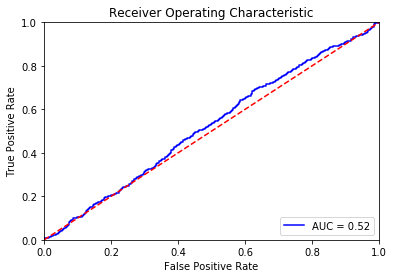

In [10]:
lr = LogisticRegression()  # initial model with original dataset

# ROC plot
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.3,random_state=0)
lr.fit(X_train, y_train)                                 # initial model
probs = lr.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('AUC =',roc_auc)   # 0.521294334691
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
lr = LogisticRegression()
params = {'C':[1.5, 2, 2.5, 3, 3.5, 4, 4.5]}
lrgrid = GridSearchCV(estimator = lr, param_grid = params, cv=5, scoring = 'accuracy',return_train_score=True)
lrgrid.fit(new_x2,train_y.values)

In [15]:
lrgrid.best_params_

{'C': 3.5}


In [58]:
# fit model on new dataframe from one-hot encoding
lr = LogisticRegression(C=3.5)
score = cross_val_score(lrmodel,new_x2,train_y, cv = 10, scoring = 'roc_auc')      
score.mean()    # 0.87897722872753992

# predict using trained logistic model
lrmodel = lr.fit(new_x2,train_y)
probs = lrmodel.predict_proba(newtest_x2)
preds_logistic = probs[:,1]

0.87897722872753992

AUC = 0.881069428452


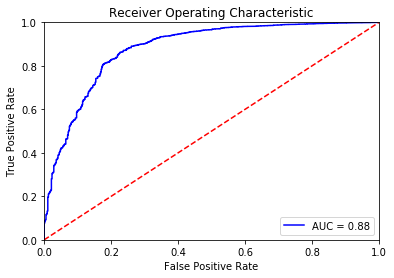

In [59]:
lrmodel = LogisticRegression(C=3.5)
X_train, X_test, y_train, y_test = train_test_split(new_x2, train_y, test_size = 0.3,random_state=0)
lrmodel.fit(X_train,y_train)                           
probs = lrmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('AUC =',roc_auc)       # 0.881069428452

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Random Forest

In [62]:
clf = RandomForestClassifier()    # initial model with no parameter
clf = clf.fit(train_x, train_y)  

AUC = 0.799255807607


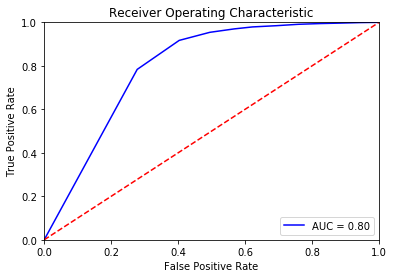

In [63]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.3,random_state=0)
clf.fit(X_train, y_train)                                 
probs = clf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('AUC =',roc_auc)          # 0.798039419179
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [85]:
# Tuning and Using the best parameters to make predictions
clf = RandomForestClassifier()
clf = clf.fit(train_x.values, train_y.values)
params = {'max_features': [0.4,0.8], 'n_estimators':[300,400],
          'min_samples_leaf':[1,2,4],'min_samples_split':[8,12],'max_depth':[7,15,20]}
RFgrid = RandomizedSearchCV(estimator = clf, param_distributions  = params, cv=5, scoring = 'accuracy',return_train_score=True)
RFgrid.fit(train_x.values,train_y.values)
print(RFgrid.best_params_)

{'n_estimators': 400, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_features': 0.8, 'max_depth': 20}


In [86]:
RFmodel = RandomForestClassifier(max_depth = 20, max_features=0.8, min_samples_leaf = 1, min_samples_split = 8, n_estimators = 400)
score = cross_val_score(RFmodel,train_x.values,train_y.values, cv = 10, scoring = 'roc_auc')
score.mean()

# predict using random forests
RFmodel.fit(train_x.values, train_y.values)
prods = RFmodel.predict_proba(test_x)
preds_rf = prods[:,1]

0.86795309136611765

AUC = 0.854655014539


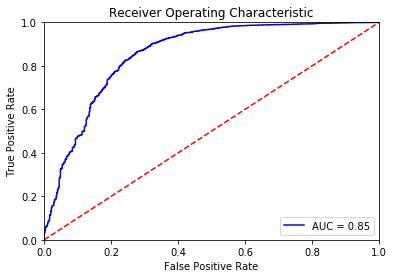

In [90]:
# final Random Forest ROC plot
RFmodel = RandomForestClassifier(max_depth = 20, max_features=0.8, min_samples_leaf = 1, min_samples_split = 8, n_estimators = 400)
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.3,random_state=0)

RFmodel.fit(X_train, y_train)                                 
probs = RFmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('AUC =', roc_auc)
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Gradient Boosting

In [64]:
clf_gb = GradientBoostingClassifier()
clf_gb.fit(train_x, train_y)     # initial model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

AUC =  0.768721539816


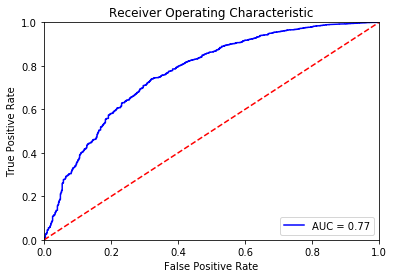

In [33]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.3,random_state=0)
clf_gb.fit(X_train, y_train) 
probs = clf_gb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('AUC = ',roc_auc )     
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [48]:
# Hyperparameter Optimization
params = {'max_depth':[5,10,15],'n_estimators':[20,30,40,50]}
GBgrid = RandomizedSearchCV(estimator = clf_gb, param_distributions = params, cv=5, scoring = 'accuracy',return_train_score=True)
GBgrid.fit(train_x,train_y)
GBgrid.best_params_

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'max_depth': [5, 10, 15], 'n_estimators': [20, 30, 40, 50]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='accuracy', verbose=0)

In [65]:
GBmodel = GradientBoostingClassifier(max_depth = 10,n_estimators = 40)
score = cross_val_score(GBmodel,train_x,train_y, cv = 10, scoring = 'roc_auc')      
score.mean()   # 0.84802305636358033

# predict using trained gradient boosting classifier
GBmodel.fit(train_x.values, train_y.values)
y_pred_class = GBmodel.predict_proba(test_x)
preds_gb = y_pred_class[:,1]

0.84802305636358033

AUC =  0.836208582592


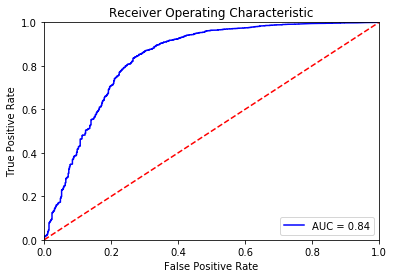

In [87]:
GBmodel = GradientBoostingClassifier(max_depth = 10,n_estimators = 40)
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.3,random_state=0)
GBmodel.fit(X_train, y_train) 
probs = GBmodel.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('AUC = ',roc_auc )
# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Ensemble VotingClassifer

In [50]:
lr = LogisticRegression(C=3.5)
lrmodel = lr.fit(new_x2,train_y)

RFmodel = RandomForestClassifier(max_depth = 20, max_features=0.8, min_samples_leaf = 1, min_samples_split = 8, n_estimators = 400)
RFmodel.fit(train_x.values, train_y.values)

GBmodel = GradientBoostingClassifier(max_depth = 10,n_estimators = 40)
GBmodel.fit(train_x.values, train_y.values)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=10,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [67]:
eclf = VotingClassifier(estimators=[('RF',RFmodel), ('LR',lrmodel),('gradient',GBmodel)],
                        voting='soft',weights=[1,1,1])

eclf.fit(train_x,train_y)
score = cross_val_score(eclf, train_x, train_y, cv=5, scoring = 'roc_auc')
score.mean()

0.86448917800081104

AUC =  0.859545788888


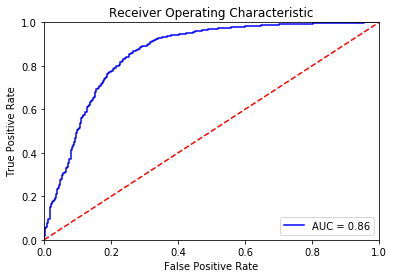

In [68]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size = 0.3,random_state=0)
eclf.fit(X_train, y_train) 
probs = eclf.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
print('AUC = ',roc_auc )   # 

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# Final Submission

In [9]:
# Logistic 
lr = LogisticRegression(C=3.5)
lrmodel = lr.fit(new_x2,train_y)
probs = lrmodel.predict_proba(newtest_x2)
preds_logistic = probs[:,1]

# random forest classifier
RFmodel = RandomForestClassifier(max_depth = 20, max_features=0.8, min_samples_leaf = 1, min_samples_split = 8, n_estimators = 400)
RFmodel.fit(train_x.values, train_y.values)
prods = RFmodel.predict_proba(test_x)
preds_rf = prods[:,1]

# gradient boosting classifier 
GBmodel = GradientBoostingClassifier(max_depth = 10,n_estimators = 40)
GBmodel.fit(train_x.values, train_y.values)
y_pred_class = GBmodel.predict_proba(test_x)
preds_gb = y_pred_class[:,1]

Action = (preds_logistic + preds_rf + preds_gb)/3
id_ = list(range(1,58922))
df = pd.DataFrame({'Id':id_,'Action':Action})
df.set_index('Id', inplace=True)
df.to_csv('FinalSubmission.csv')      # 0.8956

In [2]:
pd.read_csv('FinalSubmission.csv')

,Id,Action
0,1,0.951654
1,2,0.975694
2,3,0.989865
3,4,0.983111
4,5,0.993116
5,6,0.995916
6,7,0.962978
7,8,0.995845
8,9,0.904272
9,10,0.974563
